In [ ]:
pip install ucimlrepo

# **CItation**

In [ ]:
@misc{misc_heart_disease_45,
  author       = {Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert},
  title        = {{Heart Disease}},
  year         = {1988},
  howpublished = {UCI Machine Learning Repository},
  note         = {{DOI}: https://doi.org/10.24432/C52P4X}
}

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

# metadata
print(heart_disease.metadata)

# variable information
print(heart_disease.variables)


{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sa

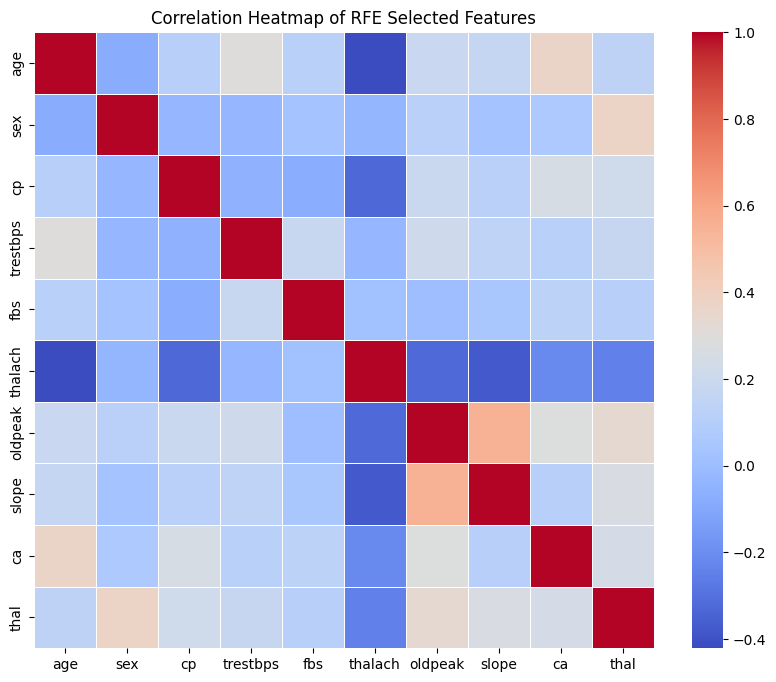

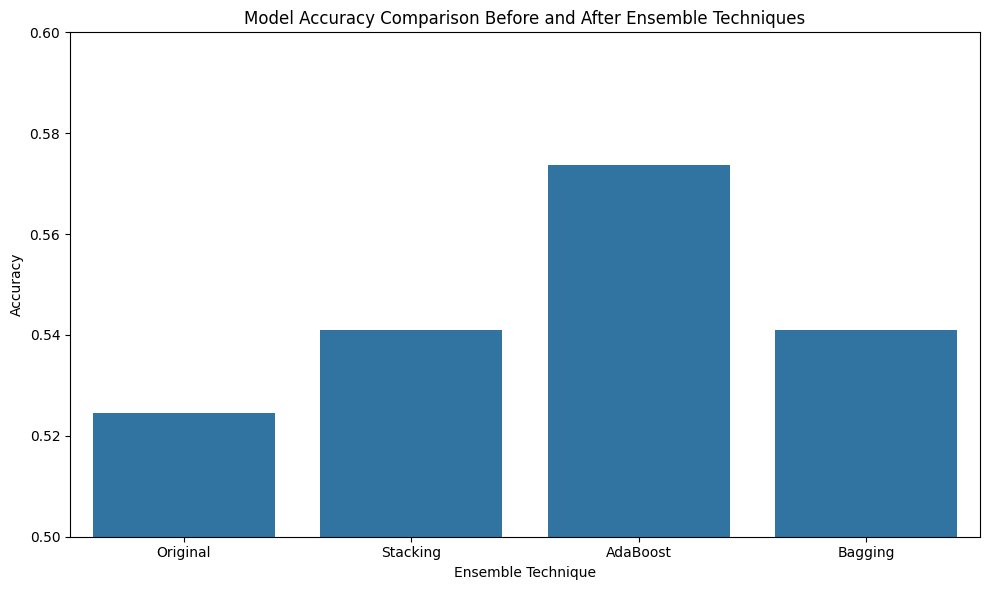

Summary of Model Accuracies:
Original: 0.5246 (52.46%)
Stacking: 0.5410 (54.10%)
AdaBoost: 0.5738 (57.38%)
Bagging: 0.5410 (54.10%)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Load the heart disease dataset
heart_disease = fetch_ucirepo(id=45)

# Data and target
X = heart_disease.data.features
y = heart_disease.data.targets

# Extracting feature names
feature_names = heart_disease.variables[heart_disease.variables['role'] == 'Feature']['name'].tolist()

# Convert the dataset to a pandas DataFrame for easier manipulation
df = pd.DataFrame(X, columns=feature_names)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Create RFE object and specify the number of features to select
rfe = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=10)

# Fit RFE to training data (excluding the target variable)
rfe.fit(X_train_scaled, y_train.values.ravel())  # Reshape y to a 1D array

# Transform the training and testing data to include only the selected features
X_train_selected = rfe.transform(X_train_scaled)
X_test_selected = rfe.transform(X_test_scaled)

# Convert selected features to DataFrame
df_selected_features = pd.DataFrame(X_train_selected, columns=[feature_names[i] for i, selected in enumerate(rfe.support_) if selected])

# Calculate correlation matrix for selected features
correlation_matrix_selected = df_selected_features.corr()

# Plot correlation heatmap for selected features
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_selected, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of RFE Selected Features')
plt.show()

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),  # Increased max_iter
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC()
}

# Train and evaluate models with all features
results_all_features = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train.values.ravel())  # Reshape y to a 1D array
    predictions = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, predictions)
    results_all_features[name] = accuracy

# Find the highest performing model
highest_model_name = max(results_all_features, key=results_all_features.get)
highest_model = models[highest_model_name]

# Train and evaluate the highest performing model with RFE-selected features
highest_model.fit(X_train_selected, y_train.values.ravel())  # Reshape y to a 1D array
accuracy_highest = highest_model.score(X_test_selected, y_test)

# Apply ensemble techniques to the highest performing model
# Stacking Classifier
stacking_model = StackingClassifier(estimators=[('highest_model', highest_model)], final_estimator=LogisticRegression(max_iter=1000))
stacking_model.fit(X_train_selected, y_train.values.ravel())  # Reshape y to a 1D array
stacking_accuracy = stacking_model.score(X_test_selected, y_test)

# AdaBoost Classifier
adaboost_model = AdaBoostClassifier(estimator=highest_model, n_estimators=100)
adaboost_model.fit(X_train_selected, y_train.values.ravel())  # Reshape y to a 1D array
adaboost_accuracy = adaboost_model.score(X_test_selected, y_test)

# Bagging Classifier
bagging_model = BaggingClassifier(estimator=highest_model, n_estimators=100)
bagging_model.fit(X_train_selected, y_train.values.ravel())  # Reshape y to a 1D array
bagging_accuracy = bagging_model.score(X_test_selected, y_test)



# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=list(models_accuracy.keys()), y=list(models_accuracy.values()))
plt.xlabel('Ensemble Technique')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison Before and After Ensemble Techniques')
plt.ylim(0.5, 0.6)  # Adjust the y-axis limits if necessary
plt.tight_layout()

# Display the plot
plt.show()


# Print summary of all scores including converted percentages
print("Summary of Model Accuracies:")
for model, accuracy in models_accuracy.items():
    accuracy_percentage = accuracy * 100
    print(f"{model}: {accuracy:.4f} ({accuracy_percentage:.2f}%)")